<a href="https://colab.research.google.com/github/visheshvg/UCS654-Predictive-Analytics-using-Statistics/blob/main/Assignment-2/Assignment_2_GAN_PDF_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim


In [4]:
df = pd.read_csv("/content/data.csv", encoding="latin1", low_memory=False)



In [6]:
x = df['no2'].dropna().values
x = x.reshape(-1, 1)


In [7]:
r = 102303961

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)


In [8]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)


In [9]:
z_tensor = torch.tensor(z_scaled, dtype=torch.float32)


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)



In [12]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
g_opt = optim.Adam(G.parameters(), lr=0.001)
d_opt = optim.Adam(D.parameters(), lr=0.001)


In [13]:
epochs = 2000
batch_size = 64

for epoch in range(epochs):
    idx = np.random.randint(0, z_tensor.shape[0], batch_size)
    real_samples = z_tensor[idx]

    # Train Discriminator
    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    d_loss_real = criterion(D(real_samples), real_labels)
    d_loss_fake = criterion(D(fake_samples.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    # Train Generator
    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    g_loss = criterion(D(fake_samples), real_labels)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.3868 | G Loss: 0.7579
Epoch 400 | D Loss: 1.2516 | G Loss: 0.7189
Epoch 800 | D Loss: 1.3575 | G Loss: 0.7091
Epoch 1200 | D Loss: 1.3511 | G Loss: 0.7669
Epoch 1600 | D Loss: 1.4127 | G Loss: 0.6506


In [14]:
with torch.no_grad():
    z_fake = G(torch.randn(5000, 1)).numpy()

z_fake = scaler.inverse_transform(z_fake).flatten()
z_real = z.flatten()


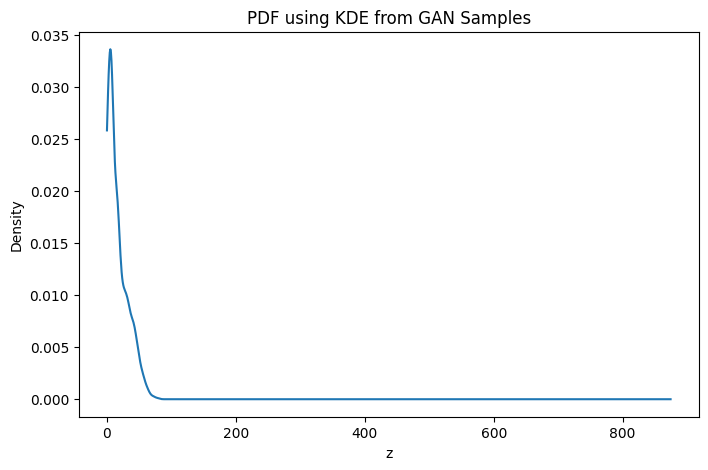

In [15]:
kde = gaussian_kde(z_fake)

z_range = np.linspace(min(z_real), max(z_real), 1000)
plt.figure(figsize=(8,5))
plt.plot(z_range, kde(z_range))
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF using KDE from GAN Samples")
plt.show()
